In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq


## 1. Tracking transfers

In [5]:
def dijkstra_with_transfers(graph, start, max_transfers):
    # Initialize distances to all nodes as infinity
    distances = {node: float('inf') for node in graph}
    # Distance from the start node to itself is 0
    distances[start] = 0
    # Priority queue to store nodes to visit, initialized with the start node
    priority_queue = [(0, start, 0)]  # (distance, node, transfers)

    while priority_queue:
        # Pop the node with the smallest distance from the priority queue
        current_distance, current_node, transfers = heapq.heappop(priority_queue)

        # If the current node has already been visited with fewer transfers, skip
        if current_distance > distances[current_node]:
            continue

        # Check if transfers exceed the maximum allowed
        if transfers > max_transfers:
            continue

        # Explore neighbors of the current node
        for neighbor, (distance, lines) in graph[current_node].items():
            new_distance = current_distance + distance
            # Calculate transfers: if the lines are different, increment transfer count
            new_transfers = transfers + (1 if len(set(graph[current_node][neighbor][1]) & set(lines)) == 0 else 0)
            # Update distance if a shorter path is found or if fewer transfers are used
            if new_distance < distances[neighbor] or (new_distance == distances[neighbor] and new_transfers < max_transfers):
                distances[neighbor] = new_distance
                # Add the neighbor to the priority queue
                heapq.heappush(priority_queue, (new_distance, neighbor, new_transfers))

    return distances


In [9]:
# Example usage:
graph = {
    'A': {'B': (3, ['line1']), 'C': (2, ['line1', 'line2']), 'D': (4, ['line2'])},
    'B': {'A': (3, ['line1']), 'C': (1, ['line2']), 'E': (5, ['line1'])},
    'C': {'A': (2, ['line1', 'line2']), 'B': (1, ['line2']), 'D': (6, ['line2'])},
    'D': {'A': (4, ['line2']), 'C': (6, ['line2']), 'E': (5, ['line1'])},
    'E': {'B': (5, ['line1']), 'D': (5, ['line1'])}
}
start_node = 'A'
max_allowed_transfers = 1
shortest_distances = dijkstra_with_transfers(graph, start_node, max_allowed_transfers)
print("Shortest distances from node", start_node + " with at most", max_allowed_transfers, "transfers:")
for node, distance in shortest_distances.items():
    print("To node", node + ":", distance)


Shortest distances from node A with at most 1 transfers:
To node A: 0
To node B: 3
To node C: 2
To node D: 4
To node E: 8


In [11]:
# # bigger example 
graph = {
    'A': {'B': (3, ['line1']), 'C': (2, ['line1', 'line2']), 'D': (4, ['line2'])},
    'B': {'A': (3, ['line1']), 'C': (1, ['line2']), 'H': (5, ['line1'])},
    'C': {'A': (2, ['line1', 'line2']), 'B': (1, ['line2']), 'D': (6, ['line2'])},
    'D': {'A': (4, ['line2']), 'C': (6, ['line2']), 'E': (5, ['line1'])},
    'E': {'B': (5, ['line1']), 'D': (5, ['line1'])},
    'F': {'G': (2, ['line1']), 'H': (2, ['line1', 'line2']), 'I': (2, ['line2'])},
    'G': {'F': (2, ['line1']), 'H': (1, ['line2']), 'C': (2, ['line1'])},
    'H': {'F': (2, ['line1', 'line2']), 'B': (1, ['line2']), 'I': (6, ['line2'])},
    'I': {'F': (2, ['line2']), 'H': (6, ['line2']), 'J': (5, ['line1'])},
    'J': {'G': (2, ['line1']), 'I': (5, ['line1'])}
}

start_node = 'A'
max_allowed_transfers = 1
shortest_distances = dijkstra_with_transfers(graph, start_node, max_allowed_transfers)
print("Shortest distances from node", start_node + " with at most", max_allowed_transfers, "transfers:")
for node, distance in shortest_distances.items():
    print("To node", node + ":", distance)

Shortest distances from node A with at most 1 transfers:
To node A: 0
To node B: 3
To node C: 2
To node D: 4
To node E: 9
To node F: 10
To node G: 12
To node H: 8
To node I: 12
To node J: 17


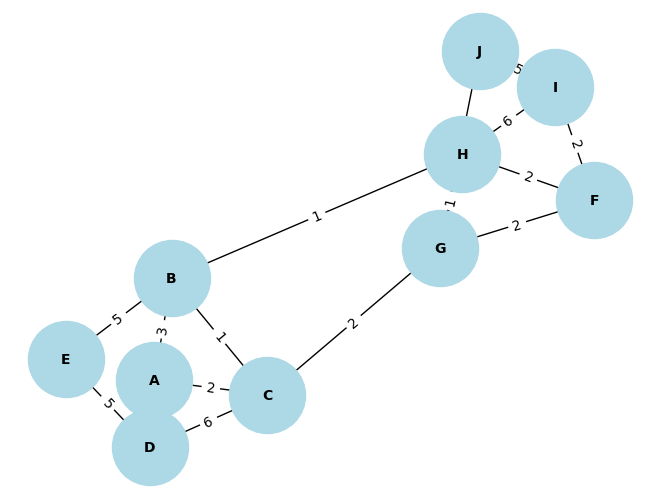

In [12]:
# visualise the graph


G = nx.Graph()
for node, neighbors in graph.items():
    for neighbor, (distance, lines) in neighbors.items():
        G.add_edge(node, neighbor, weight=distance)

pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


## 2. Accounting for start and end times

In [17]:
from collections import defaultdict, namedtuple

# Define an edge with namedtuple for better readability
Edge = namedtuple('Edge', ['to', 'weight', 'start_time', 'end_time', 'route'])

class Graph:
    def __init__(self):
        self.adj_list = defaultdict(list)

    def add_edge(self, from_node, to_node, weight, start_time, end_time, route):
        self.adj_list[from_node].append(Edge(to_node, weight, start_time, end_time, route))

def dijkstra_with_routes(graph, start, max_routes=9):
    # Initialize distances, routes, and priority queue
    distances = {node: float('inf') for node in graph.adj_list}
    distances[start] = 0
    priority_queue = [(0, start, set(), 0)]  # (time, node, routes, transfers)
    shortest_path_tree = {}
    routes_used = {node: set() for node in graph.adj_list}
    transfers = {node: float('inf') for node in graph.adj_list}
    transfers[start] = 0

    while priority_queue:
        current_time, current_node, current_routes, current_transfers = heapq.heappop(priority_queue)

        # If the popped node has a time greater than the currently known shortest time, skip it
        if current_time > distances[current_node]:
            continue

        # Examine and relax edges with time windows and route tracking
        for edge in graph.adj_list[current_node]:
            if current_time <= edge.end_time:
                # Calculate the wait time if necessary
                wait_time = max(0, edge.start_time - current_time)
                arrival_time = current_time + wait_time + edge.weight

                # Calculate the number of transfers
                new_transfers = current_transfers
                if edge.route not in current_routes:
                    new_transfers += 1

                # Check if the route can be added without exceeding the max_routes
                new_routes = current_routes | {edge.route}
                if len(new_routes) > max_routes:
                    continue

                # If this path is shorter or uses fewer routes/transfers, update the time, routes, and transfers
                if arrival_time < distances[edge.to] or (arrival_time == distances[edge.to] and new_transfers < transfers[edge.to]):
                    distances[edge.to] = arrival_time
                    routes_used[edge.to] = new_routes
                    transfers[edge.to] = new_transfers
                    heapq.heappush(priority_queue, (arrival_time, edge.to, new_routes, new_transfers))
                    shortest_path_tree[edge.to] = (current_node, edge.route)

    return distances, shortest_path_tree, routes_used, transfers

def print_shortest_path_tree(shortest_path_tree, routes_used, start):
    print("Shortest Path Tree:")
    for node, (parent, _) in shortest_path_tree.items():
        path = [node]
        while parent != start:
            path.append(parent)
            parent, _ = shortest_path_tree[parent]
        path.append(start)
        path.reverse()
        print(f"Destination Node: {node}, Path: {' -> '.join(path)}, Routes: {', '.join(routes_used[node])}")


# Example usage with a larger graph
graph = Graph()
# Adding 30 edges
edges = [
    ('A', 'B', 4, 0, 10, 'R1'), ('A', 'B', 7, 5, 15, 'R2'), ('A', 'B', 10, 10, 20, 'R3'),
    ('A', 'C', 1, 0, 5, 'R1'), ('B', 'C', 3, 2, 12, 'R2'), ('C', 'C', 5, 0, 20, 'R3'),
    ('A', 'D', 2, 0, 8, 'R1'), ('B', 'D', 4, 3, 10, 'R2'), ('C', 'D', 6, 5, 15, 'R3'),
    ('D', 'E', 3, 0, 12, 'R1'), ('E', 'F', 7, 4, 14, 'R2'), ('F', 'G', 9, 6, 18, 'R3'),
    ('G', 'H', 4, 0, 20, 'R1'), ('H', 'I', 8, 2, 22, 'R2'), ('I', 'J', 2, 1, 24, 'R3'),
    ('J', 'K', 6, 3, 26, 'R1'), ('K', 'L', 5, 5, 28, 'R2'), ('L', 'M', 7, 4, 30, 'R3'),
    ('M', 'N', 8, 6, 32, 'R1'), ('N', 'O', 9, 5, 34, 'R2'), ('O', 'P', 2, 3, 36, 'R3'),
    ('P', 'Q', 3, 7, 38, 'R1'), ('Q', 'R', 4, 8, 40, 'R2'), ('R', 'S', 5, 2, 42, 'R3'),
    ('S', 'T', 6, 1, 44, 'R1'), ('T', 'U', 7, 9, 46, 'R2'), ('U', 'V', 8, 4, 48, 'R3'),
    ('V', 'W', 9, 5, 50, 'R1'), ('W', 'X', 10, 6, 52, 'R2'), ('X', 'Y', 11, 7, 54, 'R3'),
    
    # Additional edges to ensure connectivity
    ('B', 'E', 2, 1, 10, 'R1'),  # Connect B to E
    ('D', 'F', 3, 0, 8, 'R2'),   # Connect D to F
    ('F', 'H', 5, 3, 15, 'R3'),  # Connect F to H
    ('H', 'J', 4, 1, 18, 'R1'),  # Connect H to J
    ('J', 'L', 3, 0, 20, 'R2'),  # Connect J to L
    ('L', 'N', 6, 4, 25, 'R3'),  # Connect L to N
    ('N', 'P', 2, 1, 28, 'R1'),  # Connect N to P
    ('P', 'R', 4, 3, 30, 'R2'),  # Connect P to R
    ('R', 'T', 5, 2, 32, 'R3'),  # Connect R to T
    ('T', 'V', 7, 0, 35, 'R1'),  # Connect T to V
    ('V', 'X', 3, 1, 38, 'R2'),  # Connect V to X
    ('X', 'A', 5, 4, 40, 'R3')   # Connect X to A (loop back to start)
]


for from_node, to_node, weight, start_time, end_time, route in edges:
    graph.add_edge(from_node, to_node, weight, start_time, end_time, route)

start_node = 'A'
distances, shortest_path_tree, routes_used, transfers = dijkstra_with_routes(graph, start_node, max_routes=2)

print("Travel times from start node:", distances)
print("Number of transfers:", transfers)
print_shortest_path_tree(shortest_path_tree, routes_used, start_node)


Travel times from start node: {'A': 0, 'B': 4, 'C': 1, 'D': 2, 'E': 5, 'F': 5, 'G': inf, 'H': inf, 'I': inf, 'J': inf, 'K': inf, 'L': inf, 'M': inf, 'N': inf, 'O': inf, 'P': inf, 'Q': inf, 'R': inf, 'S': inf, 'T': inf, 'U': inf, 'V': inf, 'W': inf, 'X': inf}
Number of transfers: {'A': 0, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 2, 'G': inf, 'H': inf, 'I': inf, 'J': inf, 'K': inf, 'L': inf, 'M': inf, 'N': inf, 'O': inf, 'P': inf, 'Q': inf, 'R': inf, 'S': inf, 'T': inf, 'U': inf, 'V': inf, 'W': inf, 'X': inf}
Shortest Path Tree:
Destination Node: B, Path: A -> B, Routes: R1
Destination Node: C, Path: A -> C, Routes: R1
Destination Node: D, Path: A -> D, Routes: R1
Destination Node: E, Path: A -> D -> E, Routes: R1
Destination Node: F, Path: A -> D -> F, Routes: R2, R1
